In [1]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector

In [ ]:
f9wfs = WFSFactory(wfs="f9", nzern=20, h=0.99)
f9_file = "/Users/tim/MMT/wfsdat/20170318/TREY_p500_0000.fits"
results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
plt.show()
# 265 258
# ref 240 259.5

In [ ]:
zresults = f9wfs.fit_wavefront(results, plot=True)
print(zresults['zernike'])
plt.show()

In [ ]:
zv = zresults['zernike']
zv.ignore('Z02')
zv.ignore('Z03')
zv.plot_map()
plt.show()

In [ ]:
f5wfs = WFSFactory(wfs="f5", nzern=20, back_h=0.99, pup_size=440)
f5_file = "/Users/tim/MMT/wfsdat/20170301/auto_wfs_0037_ave.fits"
results = f5wfs.measure_slopes(f5_file, 'hecto', plot=True)
plt.show()

In [ ]:
zresults = f5wfs.fit_wavefront(results, plot=True)
zv = zresults['zernike']
print(zv)
plt.show()

In [ ]:
zv.ignore('Z02')
zv.ignore('Z03')
zv.ignore('Z04')
print(zv.rms)
zv.plot_map()
plt.show()

22.0720720721 21.981981982


<IPython.core.display.Javascript object>


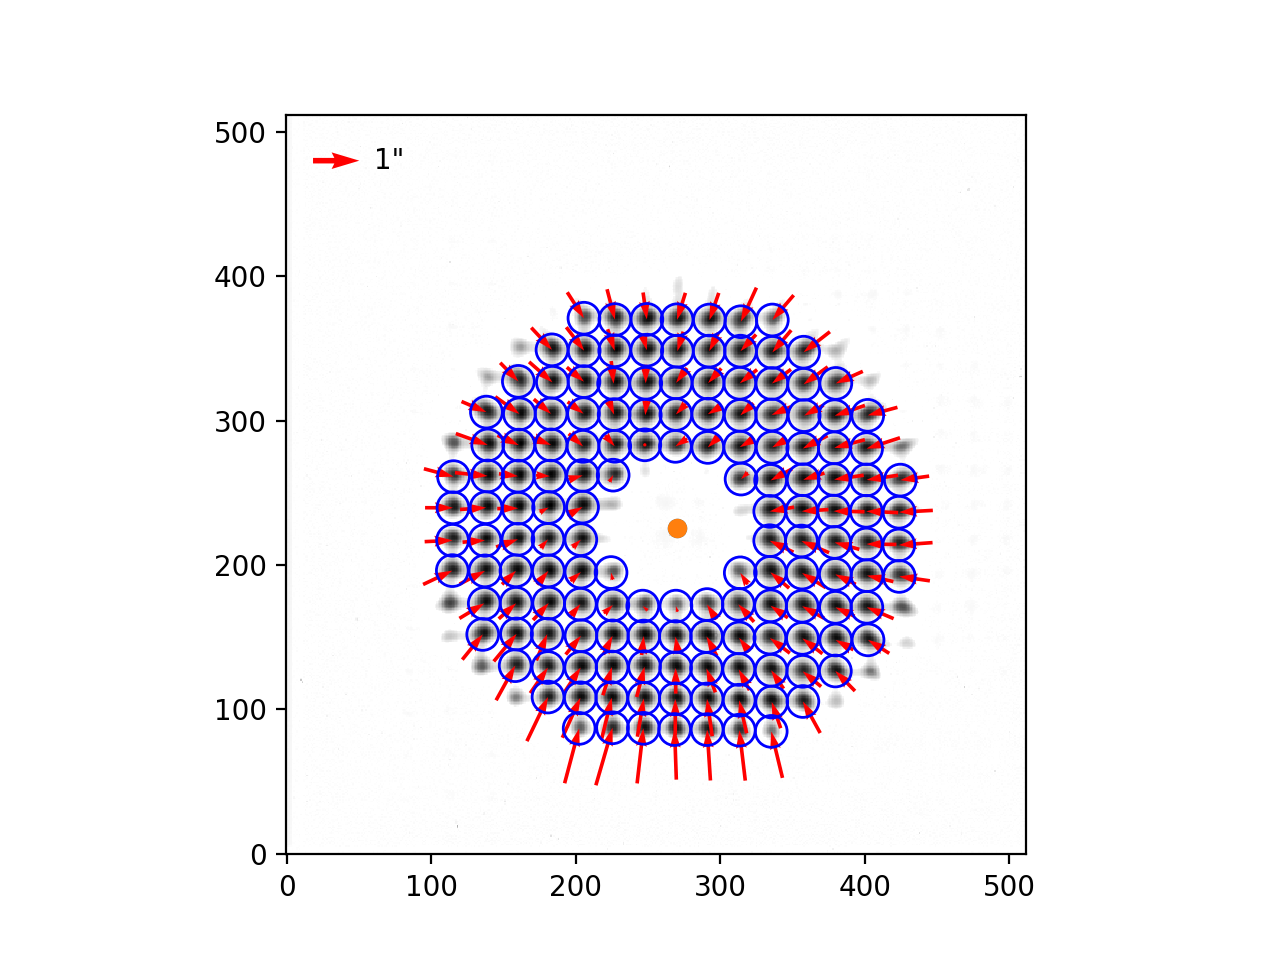

In [2]:
mmirs = WFSFactory(wfs="mmirs", nzern=20, back_h=0.9, pup_size=335)
mmirs_file = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0375.fits"
results = mmirs.measure_slopes(mmirs_file, 'mmirs2', plot=True)
plt.show()

Fringe Coefficients
 Z02:  -1.2e+03 nm 	 X Tilt (1, 1)
 Z03:  1.49e+03 nm 	 Y Tilt (1, -1)
 Z04:       998 nm 	 Defocus (2, 0)
 Z05:       394 nm 	 Primary Astig at 45˚ (2, -2)
 Z06:     -5.86 nm 	 Primary Astig at 0˚ (2, 2)
 Z07:      92.9 nm 	 Primary Y Coma (3, -1)
 Z08:       239 nm 	 Primary X Coma (3, 1)
 Z09:      -451 nm 	 Y Trefoil (3, -3)
 Z10:      -285 nm 	 X Trefoil (3, 3)
 Z11:       153 nm 	 Primary Spherical (4, 0)
 Z12:      -316 nm 	 Secondary Astigmatism at 0˚ (4, 2)
 Z13:      25.1 nm 	 Secondary Astigmatism at 45˚ (4, -2)
 Z14:       103 nm 	 X Tetrafoil (4, 4)
 Z15:      -115 nm 	 Y Tetrafoil (4, -4)
 Z16:      41.1 nm 	 Secondary X Coma (5, 1)
 Z17:       125 nm 	 Secondary Y Coma (5, -1)
 Z18:     -41.8 nm 	 Secondary X Trefoil (5, 3)
 Z19:      -120 nm 	 Secondary Y Trefoil (5, -3)
 Z20:     -56.1 nm 	 X Pentafoil (5, 5)
 Z21:      46.4 nm 	 Y Pentafoil (5, -5)



<IPython.core.display.Javascript object>


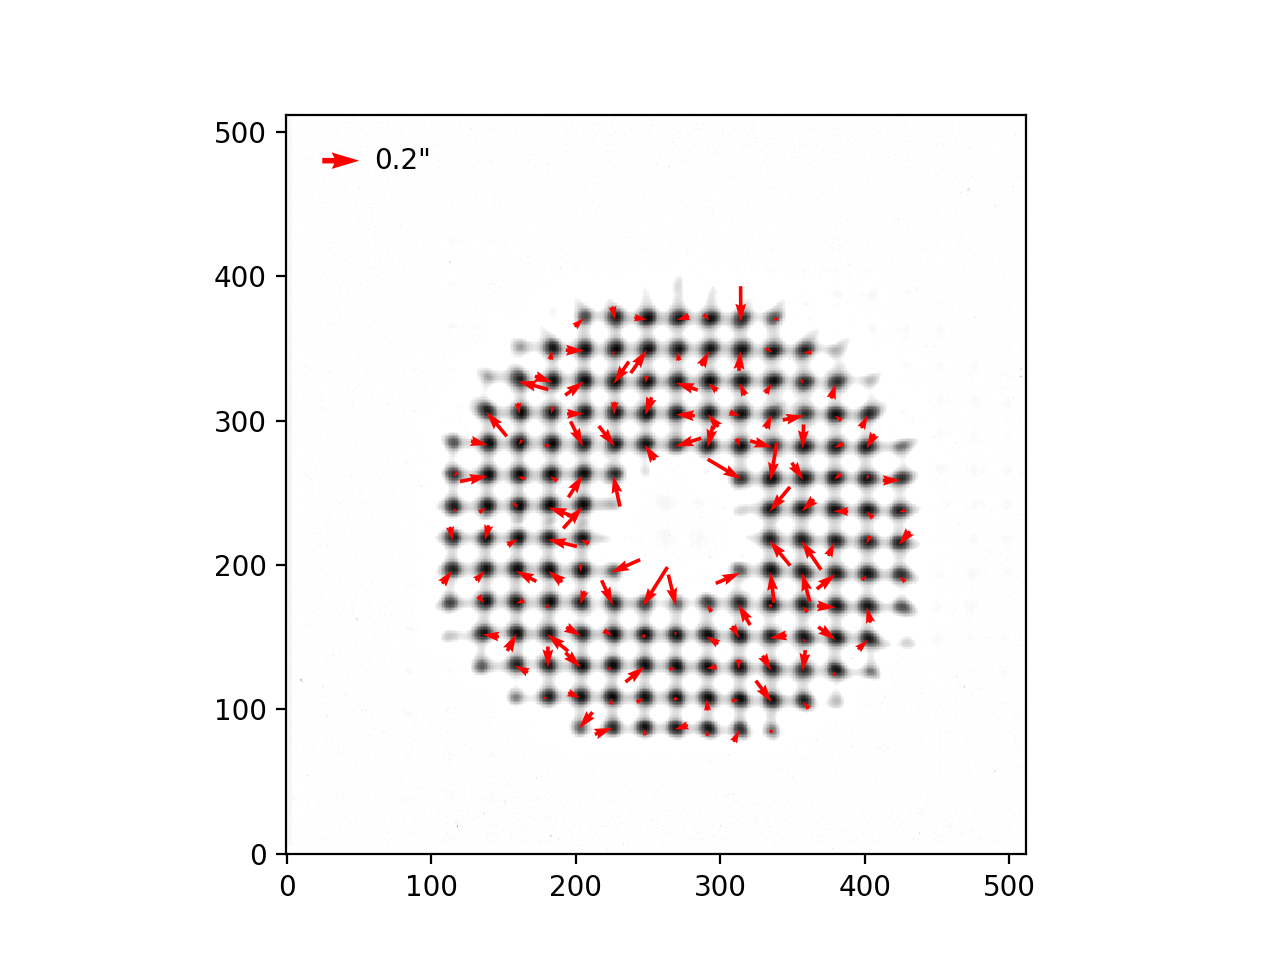

In [6]:
zresults = mmirs.fit_wavefront(results, plot=True)
zv = zresults['zernike']
print(zv)
plt.show()

In [7]:
zresults['rot_zernike'] - zresults['zernike']

Fringe Coefficients


 Z02:         0 nm 	 X Tilt (1, 1)
 Z03:         0 nm 	 Y Tilt (1, -1)
 Z04:     2e+03 nm 	 Defocus (2, 0)
 Z05:      40.7 nm 	 Primary Astig at 45˚ (2, -2)
 Z06:      2.57 nm 	 Primary Astig at 0˚ (2, 2)
 Z07:     -25.8 nm 	 Primary Y Coma (3, -1)
 Z08:    -0.812 nm 	 Primary X Coma (3, 1)
 Z09:     0.452 nm 	 Y Trefoil (3, -3)
 Z10:     -4.77 nm 	 X Trefoil (3, 3)
 Z11:     -54.1 nm 	 Primary Spherical (4, 0)
 Z12:         0 nm 	 Secondary Astigmatism at 0˚ (4, 2)
 Z13:         0 nm 	 Secondary Astigmatism at 45˚ (4, -2)
 Z14:         0 nm 	 X Tetrafoil (4, 4)
 Z15:         0 nm 	 Y Tetrafoil (4, -4)
 Z16:         0 nm 	 Secondary X Coma (5, 1)
 Z17:         0 nm 	 Secondary Y Coma (5, -1)
 Z18:         0 nm 	 Secondary X Trefoil (5, 3)
 Z19:         0 nm 	 Secondary Y Trefoil (5, -3)
 Z20:         0 nm 	 X Pentafoil (5, 5)
 Z21:         0 nm 	 Y Pentafoil (5, -5)

In [ ]:
zv.ignore('Z02')
zv.ignore('Z03')
print(zv.rms)
zv.plot_map()
plt.show()

In [ ]:
pup = f5wfs.pupil_mask(rotator=0)
plt.imshow(pup)
plt.show()

In [ ]:
im = check_wfsdata(f5_file)
back = background(im, h=0.9)
plt.imshow(im-back, origin='lower')
plt.show()

In [ ]:
subt = im - back
fits.writeto("blah.fits", subt, overwrite=True)

In [ ]:
cen = center_pupil(subt, pup, plot=True)
print(cen)
plt.show()

In [ ]:
from astropy.io import ascii

In [11]:
t = f9wfs.telescope
m = t.zern_map

NameError: name 'f9wfs' is not defined

In [12]:
z = np.loadtxt("/Users/tim/MMT/wfsdat/20170110/mmirs_wfs_0375.dao.sub.zrn.cor")
z1 = np.loadtxt("/Users/tim/MMT/wfsdat/20170110/mmirs_wfs_0375.dao.av.zrn")

In [14]:
z1 - z

array([  0.00000000e+00,   0.00000000e+00,   2.00186718e+03,
         3.92539676e+01,   2.47514620e+00,  -5.88222614e+01,
        -1.85266960e+00,  -1.67883389e+01,   5.28378167e+01,
         5.00579600e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

In [10]:
Z = ZernikeVector(coeffs=z, zmap=m)

NameError: name 'm' is not defined

In [ ]:
Z

In [ ]:
from astropy.table import Table
from astropy.io import ascii

In [ ]:
t = ascii.read("/Users/tim/MMT/mmtwfs/mmtwfs/data/mmirszernfield.tab")

In [ ]:
t

In [ ]:
np.interp(0.12, t['field_r'], t['Z01'])

In [ ]:
range(4, 11)

In [ ]:
for i in range(4, 12):
    print("Z%02d" % i)